# I. Setting up the Problem

In [83]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [84]:
filename ="CrowdstormingDataJuly1st.csv"
Data = pd.read_csv(filename)

### 1) Peeking into the Data

In [85]:
Data.ix[:10,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0


In [86]:
Data.ix[:10,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# II. Preparing data

### 1) Keep only players that have a Rater Image

In [87]:
# Remove the players without rater 1 / 2 (ie: without photo) because we won't be 
# able to train or test the values (this can be done as bonus later)

Data_hasImage = Data[pd.notnull(Data['photoID'])]

### 2) Getting rif of referees and grouping data by soccer player

We need to aggregate the information about referees and group the result by soccer player. It means that each line will correspond to a soccer player, with the sum of all the cards he got, and we won't know anymore who gaves the cards.

In [88]:
# Group by player and do the sum of every column, except for mean_rater (skin color) that we need to move away during the calculation (we don't want to sum skin color values !)
Data_aggregated = Data_hasImage.drop(['refNum', 'refCountry'], 1)
Data_aggregated = Data_aggregated.groupby(['playerShort', 'position'])['games','yellowCards', 'yellowReds', 'redCards'].sum()
Data_aggregated = Data_aggregated.reset_index()

# Take information of skin color for each player
Data_nbGames_skinColor = Data_hasImage
Data_nbGames_skinColor.drop_duplicates('playerShort')
Data_nbGames_skinColor['skinColor']=(Data_nbGames_skinColor['rater1']+Data_hasImage['rater2'])/2
Data_nbGames_skinColor = pd.DataFrame(Data_nbGames_skinColor[['playerShort','skinColor']])
Data_aggregated = pd.merge(left=Data_aggregated,right=Data_nbGames_skinColor, how='left', left_on='playerShort', right_on='playerShort')
Data_aggregated = Data_aggregated.drop_duplicates('playerShort')
Data_aggregated = Data_aggregated.reset_index(drop=True)
Data_aggregated

C:\Users\merin\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,playerShort,position,games,yellowCards,yellowReds,redCards,skinColor
0,aaron-hughes,Center Back,654,19,0,0,0.125
1,aaron-hunt,Attacking Midfielder,336,42,0,1,0.125
2,aaron-lennon,Right Midfielder,412,11,0,0,0.250
3,aaron-ramsey,Center Midfielder,260,31,0,1,0.000
4,abdelhamid-el-kaoutari,Center Back,124,8,4,2,0.250
5,abdou-traore_2,Right Midfielder,97,11,1,0,0.750
6,abdoulaye-diallo_2,Goalkeeper,24,0,0,0,0.875
7,abdoulaye-keita_2,Goalkeeper,3,0,0,0,0.875
8,abdoulwhaid-sissoko,Defensive Midfielder,121,21,0,2,1.000
9,abdul-rahman-baba,Left Fullback,50,3,0,1,0.875


# III. Unsupervized machine learning

The first idea we got is to start an unsupervized learning kept as simple as possible.

We will have to take player position, the three types of cards and the skin color: that makes 5 dimensions to deal with !

Instead, let say we only look at the total number of cards the players got, and their skin color. Then we would be able to display something in 2 dimensions only:

<img src="resources/axis_assumption.jpg" alt="Drawing" style="width: 600px;"/>

Then, we would try to obtain two clusters that might lead to really simple conclusion such as "dark people slightly tend to get more cards":

<img src="resources/axis_assumption_clustered.jpg" alt="Drawing" style="width: 600px;"/>

Again, this is totally hypothetical. So let's give it a try.
We try to use a K means clustering methode to obtain 2 distinct clusters, with the help of this website:
http://stamfordresearch.com/k-means-clustering-in-python/

In [89]:
# Input
x = Data_aggregated
x = x.drop(['playerShort'], 1)

# We have to convert every columns to floats, to be able to train our model
mapping = {'Center Back': 1, 'Attacking Midfielder': 2, 'Right Midfielder': 3, 'Center Midfielder': 4, 'Defensive Midfielder': 5, 'Goalkeeper':6, 'Left Fullback':7, 'Left Midfielder':8, 'Right Fullback':9, 'Center Forward':10, 'Left Winger':11, 'Right Winger':12}
x = x.replace({'position': mapping})
x

,position,games,yellowCards,yellowReds,redCards,skinColor
0,1,654,19,0,0,0.125
1,2,336,42,0,1,0.125
2,3,412,11,0,0,0.250
3,4,260,31,0,1,0.000
4,1,124,8,4,2,0.250
5,3,97,11,1,0,0.750
6,6,24,0,0,0,0.875
7,6,3,0,0,0,0.875
8,5,121,21,0,2,1.000
9,7,50,3,0,1,0.875


In [90]:
# Output with the same length as the input, that will contains the associated cluster
y = pd.DataFrame(index=x.index, columns=['targetCluster'])
y.head()

,targetCluster
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [91]:
# Create a colormap for target clusters (only 2)
colormap = np.array(['red', 'lime'])

# K Means Cluster
model = KMeans(n_clusters=2)
model = model.fit(x)
model

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [92]:
# We got a model with two clusters
model.labels_

array([1, 1, 1, ..., 1, 0, 0])

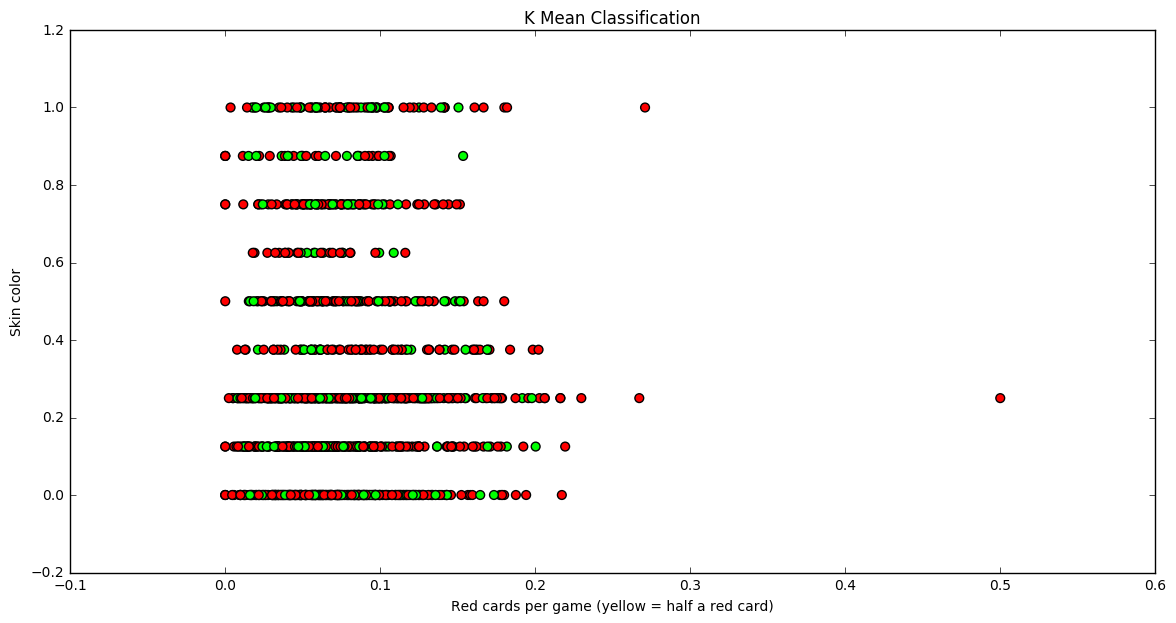

In [93]:
# View the results
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap for the two clusters
colormap = np.array(['red', 'lime'])
 
# Plot the Model Classification PARTIALLY
plt.scatter((0.5*x.yellowCards + x.yellowReds + x.redCards)/x.games, x.skinColor, c=colormap[model.labels_], s=40)
plt.xlabel('Red cards per game (yellow = half a red card)')
plt.ylabel('Skin color')
plt.title('K Mean Classification')
plt.show()

(We show only skin color and number of "red cards" because it's a 2D plot, but we actually used 5 parameters: position, yellowCards, yellowReds, redCards and number of games. So this graph doesn't really represent how our data has been clustered.
This is only to check if some clustering has ben done. Here we don't really see two distincts clusters. It looks like more random coloring ! :x

Now, let's add the result to each player:

In [94]:
cluster = pd.DataFrame(pd.Series(model.labels_, name='cluster'))
Data_Clustered = Data_aggregated
Data_Clustered['cluster'] = cluster
Data_Clustered

,playerShort,position,games,yellowCards,yellowReds,redCards,skinColor,cluster
0,aaron-hughes,Center Back,654,19,0,0,0.125,1
1,aaron-hunt,Attacking Midfielder,336,42,0,1,0.125,1
2,aaron-lennon,Right Midfielder,412,11,0,0,0.250,1
3,aaron-ramsey,Center Midfielder,260,31,0,1,0.000,0
4,abdelhamid-el-kaoutari,Center Back,124,8,4,2,0.250,0
5,abdou-traore_2,Right Midfielder,97,11,1,0,0.750,0
6,abdoulaye-diallo_2,Goalkeeper,24,0,0,0,0.875,0
7,abdoulaye-keita_2,Goalkeeper,3,0,0,0,0.875,0
8,abdoulwhaid-sissoko,Defensive Midfielder,121,21,0,2,1.000,0
9,abdul-rahman-baba,Left Fullback,50,3,0,1,0.875,0


So, do we have any new information ? What can we conclude of this ?
We can use the "silhouette score", which is a metric showing if the two clusters are well separated. It it's equals to 1, the clusters are perfectly separated, and if it's 0, the clustering doesn't make any sense.

In [96]:
#score = silhouette_score(x.as_matrix, model.labels_, metric="euclidean")
score = silhouette_score(x, model.labels_)
score

0.57982765748640508

We got a silhouette score of 58%, which is honestly not really meaningful. We cannot rely on this model.